In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
import pandas as pd
import numpy as np
from pathlib import Path
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import KFold

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
!pip install tensorflow-addons

     |████████████████████████████████| 1.1 MB 5.3 MB/s 


In [ ]:
import tensorflow_addons
from tensorflow_addons.metrics import CohenKappa

# Copy dataset to local storage from gDrive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp /content/drive/MyDrive/MURA/MURA-v1.1.zip .

!unzip -q MURA-v1.1.zip

!rm MURA-v1.1.zip

# Create train and validation dataframes

In [ ]:
root_path = Path('./MURA-v1.1')

train_paths = pd.read_csv(root_path/'train_image_paths.csv', header=None, names=['filename'])
valid_paths = pd.read_csv(root_path/'valid_image_paths.csv', header=None, names=['filename'])

train_paths['class'] = (train_paths.filename.str.extract('(positive|negative)'))
valid_paths['class'] = (valid_paths.filename.str.extract('(positive|negative)'))

full_dataset = pd.concat([train_paths, valid_paths])

# Create datagen

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rotation_range=10,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             zoom_range=0.3,
                             horizontal_flip=True,
                             fill_mode='nearest',
                             rescale=1./255)

# Function for training with cross validation

In [ ]:
def train_validate(model_base, dataset, n_folds, n_epochs):
  kf = KFold(n_splits=n_folds, shuffle=True, random_state=27)
  val_acc = []
  val_loss = []

  fold = 1
  for train_index, val_index in kf.split(dataset):
    tf.keras.backend.clear_session()

    train = dataset.iloc[train_index]
    valid = dataset.iloc[val_index]
    
    train_datagen = datagen.flow_from_dataframe(train,
                                                directory=root_path.parent,
                                                target_size=(224, 224),
                                                batch_size=32,
                                                class_mode='binary')

    valid_datagen = datagen.flow_from_dataframe(valid,
                                                directory=root_path.parent,
                                                target_size=(224, 224),
                                                batch_size=32,
                                                class_mode='binary')
    
    model = tf.keras.models.clone_model(model_base)
    model.compile(loss=tf.keras.losses.binary_crossentropy,
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

    print('------------------------------------------------------------------------')
    print(f'Training fold: {fold}')

    hist = model.fit(train_datagen,epochs=n_epochs)
    
    scores = model.evaluate(valid_datagen, verbose=0)
    print(f'Score for fold {fold}: {model.metrics_names[0]} of {scores[0]:.4f}; {model.metrics_names[1]} of {scores[1]:.4f}')
    val_acc.append(scores[1])
    val_loss.append(scores[0])

    model.save(model.name + '_' + str(fold))
    fold += 1
  
  print('------------------------------------------------------------------------')
  print('Score per fold')
  for i in range(0, len(val_acc)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {val_loss[i]:.4f} - Accuracy: {val_acc[i]:.4f}')
  print('------------------------------------------------------------------------')
  print('Average scores for all folds:')
  print(f'> Accuracy: {np.mean(val_acc):.4f} (+- {np.std(val_acc):.4f})')
  print(f'> Loss: {np.mean(val_loss):.4f}')
  print('------------------------------------------------------------------------')

#DenseNet with custom layers

Using DenseNet169 model with pretrained weights from ImageNet, top layer is replaced with a number of custom layers which are trained, DenseNet169 layers are frozen and then fine-tuned.

In [ ]:
# Download DenseNet169
densenet = tf.keras.applications.DenseNet169(weights='imagenet',
                                             include_top = False,
                                             input_shape=(224, 224, 3))
densenet.trainable = False

# Build the model with DenseNet and custom layers on top
inputs = tf.keras.Input(shape=(224, 224, 3))

x = densenet(inputs, training=False)

x = tf.keras.layers.Flatten()(x)

x = tf.keras.layers.BatchNormalization()(x)

x = tf.keras.layers.Dense(units=256,activation='relu')(x)

x = tf.keras.layers.Dropout(0.4)(x)

x = tf.keras.layers.BatchNormalization()(x)

x = tf.keras.layers.Dense(units=128,activation='relu')(x)

x = tf.keras.layers.Dropout(0.2)(x)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(inputs, outputs, name='densenet169_custom')

model.summary()

51879936/51877672 [==============================] - 2s 0us/step
Model: "densenet169_custom"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
densenet169 (Functional)     (None, 7, 7, 1664)        12642880  
_________________________________________________________________
flatten (Flatten)            (None, 81536)             0         
_________________________________________________________________
batch_normalization (BatchNo (None, 81536)             326144    
_________________________________________________________________
dense (Dense)                (None, 256)               20873472  
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________

In [ ]:
# Trying to train longer on normal train validation split

model.compile(loss=tf.keras.losses.binary_crossentropy,
                            optimizer=tf.keras.optimizers.Adam(),
                            metrics=[cohen_kappa_score])

hist = model.fit(train_gen, epochs=30, validation_data=valid_gen)
# model.save('densenetCustom')
# !cp -r ./densenetCustom /content/drive/MyDrive/MURA

###Train with cross validation

In [ ]:
train_validate(model, full_dataset, 5, 5)

Found 32004 validated image filenames belonging to 2 classes.
Found 8001 validated image filenames belonging to 2 classes.
------------------------------------------------------------------------
Training fold: 1
Epoch 1/5
1001/1001 [==============================] - 436s 428ms/step - loss: 0.7341 - accuracy: 0.5514
Epoch 2/5
1001/1001 [==============================] - 430s 430ms/step - loss: 0.6762 - accuracy: 0.5823
Epoch 3/5
1001/1001 [==============================] - 427s 427ms/step - loss: 0.6697 - accuracy: 0.5886
Epoch 4/5
1001/1001 [==============================] - 427s 427ms/step - loss: 0.6684 - accuracy: 0.5926
Epoch 5/5
1001/1001 [==============================] - 428s 427ms/step - loss: 0.6694 - accuracy: 0.5847
Score for fold 1: loss of 0.6614; accuracy of 0.5987
INFO:tensorflow:Assets written to: densenet169_1/assets
Found 32004 validated image filenames belonging to 2 classes.
Found 8001 validated image filenames belonging to 2 classes.
------------------------------

In [ ]:
# Storing model on gDrive for later use
!cp -r ./densenet169_5 /content/drive/MyDrive/MURA

cp: cannot stat './densenet169_5': No such file or directory


### Fine tuning on one of the folds

In [ ]:
reconstructed_model = tf.keras.models.load_model(model.name + '_5')

# Freeze densenet layers
densenet_layer = reconstructed_model.layers[1]
for layer in densenet_layer.layers:
  layer.trainable = False

# Unfreezing top 30 layers
for layer in densenet_layer.layers[-30:]:
  if not isinstance(layer, tf.keras.layers.BatchNormalization):
    layer.trainable = True

In [ ]:
# Verifying that layers are not frozen
dl = reconstructed_model.layers[1]
for layer in dl.layers[-30:]:
  print(layer.name + " " + str(layer.trainable))

conv5_block29_0_bn False
conv5_block29_0_relu True
conv5_block29_1_conv True
conv5_block29_1_bn False
conv5_block29_1_relu True
conv5_block29_2_conv True
conv5_block29_concat True
conv5_block30_0_bn False
conv5_block30_0_relu True
conv5_block30_1_conv True
conv5_block30_1_bn False
conv5_block30_1_relu True
conv5_block30_2_conv True
conv5_block30_concat True
conv5_block31_0_bn False
conv5_block31_0_relu True
conv5_block31_1_conv True
conv5_block31_1_bn False
conv5_block31_1_relu True
conv5_block31_2_conv True
conv5_block31_concat True
conv5_block32_0_bn False
conv5_block32_0_relu True
conv5_block32_1_conv True
conv5_block32_1_bn False
conv5_block32_1_relu True
conv5_block32_2_conv True
conv5_block32_concat True
bn False
relu True


### Split data according to corresponding fold

In [ ]:

kf = KFold(n_splits=5, shuffle=True, random_state=27)
folds = []
for ftrain, fvalid in  kf.split(full_dataset):
  folds.append((ftrain, fvalid))

ftrain = full_dataset.iloc[folds[4][0]]
fvalid = full_dataset.iloc[folds[4][1]]

### Create generators

In [ ]:
ftrain_datagen = datagen.flow_from_dataframe(ftrain,
                                            directory=root_path.parent,
                                            target_size=(224, 224),
                                            batch_size=32,
                                            class_mode='binary')

fvalid_datagen = datagen.flow_from_dataframe(fvalid,
                                            directory=root_path.parent,
                                            target_size=(224, 224),
                                            batch_size=32,
                                            class_mode='binary')

NameError: ignored

### Fine tune model

In [ ]:
reconstructed_model.compile(loss=tf.keras.losses.binary_crossentropy,
                            optimizer=tf.keras.optimizers.Adam(1e-4),
                            metrics=['accuracy'])

hist = reconstructed_model.fit(ftrain_datagen, epochs=5)
reconstructed_model.evaluate(fvalid_datagen)

Epoch 1/5
1001/1001 [==============================] - 470s 462ms/step - loss: 0.6615 - accuracy: 0.6023
Epoch 2/5
1001/1001 [==============================] - 455s 455ms/step - loss: 0.6592 - accuracy: 0.6029
Epoch 3/5
1001/1001 [==============================] - 456s 455ms/step - loss: 0.6505 - accuracy: 0.6119
Epoch 4/5
1001/1001 [==============================] - 453s 452ms/step - loss: 0.6548 - accuracy: 0.6098
Epoch 5/5
251/251 [==============================] - 121s 471ms/step - loss: 0.6545 - accuracy: 0.6034


[0.6544771790504456, 0.6034245491027832]

# Model comparison

## Create generators used without cross validation

In [ ]:
train_gen = datagen.flow_from_dataframe(train_paths,
                                        directory=root_path.parent,
                                        target_size=(224, 224),
                                        batch_size=32,
                                        class_mode='binary')

valid_datagen = ImageDataGenerator(rescale=1./255)

valid_gen = valid_datagen.flow_from_dataframe(valid_paths,
                                        directory=root_path.parent,
                                        target_size=(224, 224),
                                        batch_size=32,
                                        class_mode='binary')

Found 36808 validated image filenames belonging to 2 classes.
Found 3197 validated image filenames belonging to 2 classes.


# DenseNet169

In [ ]:
# Download DenseNet169
densenet169 = tf.keras.applications.DenseNet169(weights='imagenet',
                                       include_top = False,
                                       input_shape=(224, 224, 3))
densenet169.trainable = False

# Build the model with DenseNet169 and custom layers on top
inputs = tf.keras.Input(shape=(224, 224, 3))

x = densenet169(inputs, training=False)

x = tf.keras.layers.Flatten()(x)

x = tf.keras.layers.Dropout(0.2)(x)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(inputs, outputs, name='densenet169')

model.summary()

Model: "densenet169"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
densenet169 (Functional)     (None, 7, 7, 1664)        12642880  
_________________________________________________________________
flatten_3 (Flatten)          (None, 81536)             0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 81536)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 81537     
Total params: 12,724,417
Trainable params: 81,537
Non-trainable params: 12,642,880
_________________________________________________________________


In [ ]:
kappa_metric = CohenKappa(num_classes=2, name='cohenkappa')

model.compile(loss=tf.keras.losses.binary_crossentropy,
                            optimizer=tf.keras.optimizers.Adam(),
                            metrics=kappa_metric)

checkpoint_filepath = 'densenet.{epoch:02d}-{val_loss:.2f}'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_cohenkappa',
    mode='max',
    save_best_only=True)

hist = model.fit(train_gen, epochs=5, validation_data=valid_gen, callbacks=[model_checkpoint_callback])

Epoch 1/5
1151/1151 [==============================] - 678s 580ms/step - loss: 1.6004 - cohenkappa: 0.2989 - val_loss: 1.4988 - val_cohenkappa: 0.3616
Epoch 2/5
1151/1151 [==============================] - 664s 576ms/step - loss: 1.6414 - cohenkappa: 0.3079 - val_loss: 1.9616 - val_cohenkappa: 0.3208
Epoch 3/5
1151/1151 [==============================] - 664s 577ms/step - loss: 1.6727 - cohenkappa: 0.3184 - val_loss: 2.3189 - val_cohenkappa: 0.3194
Epoch 4/5
1151/1151 [==============================] - 666s 579ms/step - loss: 1.7406 - cohenkappa: 0.3125 - val_loss: 1.4524 - val_cohenkappa: 0.3649
Epoch 5/5
1151/1151 [==============================] - 665s 578ms/step - loss: 1.8446 - cohenkappa: 0.3056 - val_loss: 1.8445 - val_cohenkappa: 0.3685


In [ ]:

model.save(model.name)

INFO:tensorflow:Assets written to: densenet169/assets


INFO:tensorflow:Assets written to: densenet169/assets


# VGG16

In [ ]:
# Download VGG16
vgg16 = tf.keras.applications.VGG16(weights='imagenet',
                                       include_top = False,
                                       input_shape=(224, 224, 3))
vgg16.trainable = False

# Build the model with VGG16 and custom layers on top
inputs = tf.keras.Input(shape=(224, 224, 3))

x = vgg16(inputs, training=False)

x = tf.keras.layers.Flatten()(x)

x = tf.keras.layers.Dropout(0.2)(x)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(inputs, outputs, name='vgg16')

model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 25089     
Total params: 14,739,777
Trainable params: 25,089
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
model.compile(loss=tf.keras.losses.binary_crossentropy,
                            optimizer=tf.keras.optimizers.Adam(),
                            metrics=['accuracy'])

hist = model.fit(train_gen, epochs=5, validation_data=valid_gen)

Epoch 1/5
1151/1151 [==============================] - 549s 475ms/step - loss: 0.6737 - accuracy: 0.6200 - val_loss: 0.6181 - val_accuracy: 0.6606
Epoch 2/5
1151/1151 [==============================] - 547s 475ms/step - loss: 0.6300 - accuracy: 0.6639 - val_loss: 0.6080 - val_accuracy: 0.6728
Epoch 3/5
1151/1151 [==============================] - 547s 475ms/step - loss: 0.6368 - accuracy: 0.6545 - val_loss: 0.6058 - val_accuracy: 0.6600
Epoch 4/5
1151/1151 [==============================] - 546s 474ms/step - loss: 0.6345 - accuracy: 0.6642 - val_loss: 0.6447 - val_accuracy: 0.6362
Epoch 5/5
1151/1151 [==============================] - 544s 472ms/step - loss: 0.6404 - accuracy: 0.6646 - val_loss: 0.6057 - val_accuracy: 0.6697


In [ ]:
model.save(model.name)

INFO:tensorflow:Assets written to: vgg16/assets


# ResNet50

In [ ]:
# Download ResNet50
resnet50 = tf.keras.applications.ResNet50(weights='imagenet',
                                          include_top = False,
                                          input_shape=(224, 224, 3))
resnet50.trainable = False

# Build the model with ResNet50 and custom layers on top
inputs = tf.keras.Input(shape=(224, 224, 3))

x = resnet50(inputs, training=False)

x = tf.keras.layers.Flatten()(x)

x = tf.keras.layers.Dropout(0.2)(x)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(inputs, outputs, name='resnet50')

model.summary()

94773248/94765736 [==============================] - 1s 0us/step
Model: "resnet50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten_2 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 100352)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 100353    
Total params: 23,688,065
Trainable params: 100,353
Non-trainable params: 23,587,712
_________________________________________________________________


In [ ]:
model.compile(loss=tf.keras.losses.binary_crossentropy,
                            optimizer=tf.keras.optimizers.Adam(),
                            metrics=['accuracy'])

hist = model.fit(train_gen, epochs=5, validation_data=valid_gen)

Epoch 1/5
1151/1151 [==============================] - 550s 475ms/step - loss: 0.8956 - accuracy: 0.5484 - val_loss: 0.7662 - val_accuracy: 0.5161
Epoch 2/5
1151/1151 [==============================] - 545s 473ms/step - loss: 0.7962 - accuracy: 0.5652 - val_loss: 0.6619 - val_accuracy: 0.5887
Epoch 3/5
1151/1151 [==============================] - 546s 474ms/step - loss: 0.8330 - accuracy: 0.5569 - val_loss: 0.6635 - val_accuracy: 0.6056
Epoch 4/5
1151/1151 [==============================] - 543s 472ms/step - loss: 0.7998 - accuracy: 0.5610 - val_loss: 0.8188 - val_accuracy: 0.5252
Epoch 5/5
1151/1151 [==============================] - 543s 472ms/step - loss: 0.8165 - accuracy: 0.5591 - val_loss: 0.6993 - val_accuracy: 0.5840


In [ ]:
model.save(model.name)

INFO:tensorflow:Assets written to: resnet50/assets


In [ ]:
# Store trained models on gDrive for later use
!cp -r ./vgg16 /content/drive/MyDrive/MURA
!cp -r ./resnet50 /content/drive/MyDrive/MURA
!cp -r ./densenet169 /content/drive/MyDrive/MURA

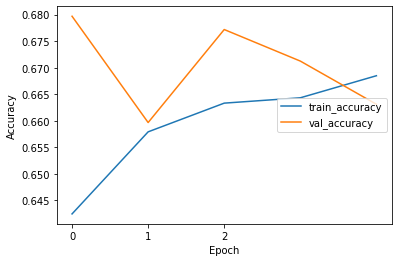

In [ ]:
plt.plot(hist.history['accuracy'], label='train_accuracy')
plt.plot(hist.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='right')
plt.xticks(np.arange(3))

plt.show()

# Grad-CAM

In [ ]:
from IPython.display import Image
import matplotlib.cm as cm
import cv2

In [ ]:
!cp -r /content/drive/MyDrive/MURA/vgg16 ./
model = tf.keras.models.load_model('vgg16')
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dropout_1 (Dropout)         (None, 25088)             0         
                                                                 
 dense_1 (Dense)             (None, 1)                 25089     
                                                                 
Total params: 14,739,777
Trainable params: 25,089
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
vgg_16 = model.get_layer('vgg16')
vgg_16.layers


grad_model = keras.Model(vgg_16.inputs, vgg_16.output)
grad_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:

prediction = np.round(np.asarray(model.predict(valid_gen)))
prediction = prediction.astype(int).flatten()

In [ ]:
metric = CohenKappa(num_classes=2)
metric.update_state(valid_gen.classes, prediction)
result = metric.result()
print("Cohen Kappa score", result.numpy())


Cohen Kappa score -0.026060343


In [ ]:
img_size = (224, 224)

last_conv_layer_name = "conv5_block32_concat"
classifier_layer_names = [
    "flatten_1",
    "dropout_1",
    "dense_1"
]

In [ ]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(
    img_array, model, last_conv_layer_name, classifier_layer_names
):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer
    last_conv_layer = model.get_layer('densenet169').get_layer(last_conv_layer_name)
    last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)

    # Second, we create a model that maps the activations of the last conv
    # layer to the final class predictions
    classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    classifier_model = keras.Model(classifier_input, x)

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        # Compute activations of the last conv layer and make the tape watch it
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        # Compute class predictions
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]

    # This is the gradient of the top predicted class with regard to
    # the output feature map of the last conv layer
    grads = tape.gradient(top_class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    heatmap = np.mean(last_conv_layer_output, axis=-1)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap

In [ ]:
# Prepare image
img_array = get_img_array(full_dataset.iloc[15][0], (224, 224))

# Print what the top predicted class is
preds = model.predict(img_array)
print("Predicted:", preds[0][0])

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(
    img_array,
    model,
    last_conv_layer_name,
    classifier_layer_names
)

# Display heatmap
plt.matshow(heatmap)
plt.show()


Predicted: 1.0


ValueError: ignored

In [ ]:
# We load the original image
img = keras.preprocessing.image.load_img(full_dataset.iloc[15][0])
img = keras.preprocessing.image.img_to_array(img)

# We rescale heatmap to a range 0-255
heatmap = np.uint8(255 * heatmap)

# We use jet colormap to colorize heatmap
jet = cm.get_cmap("jet")

# We use RGB values of the colormap
jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]

# We create an image with RGB colorized heatmap
jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

# Superimpose the heatmap on original image
superimposed_img = jet_heatmap * 0.4 + img
superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

# Save the superimposed image
save_path = "xray_cam.jpg"
superimposed_img.save(save_path)

# Display Grad CAM
display(Image(save_path))
